In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_data = pd.read_csv('ventilator-pressure-prediction/train.csv',index_col=0)
test_data  = pd.read_csv('ventilator-pressure-prediction/test.csv', index_col=0)
sample     = pd.read_csv('ventilator-pressure-prediction/sample_submission.csv')

In [3]:
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035998,125749,50,10,2.571408,1.558978,1,3.798729


In [4]:
train_data.nunique().to_frame()

,0
breath_id,75450
R,3
C,3
time_step,3767571
u_in,4020300
u_out,2
pressure,950


In [5]:
test_data.nunique().to_frame()

,0
breath_id,50300
R,3
C,3
time_step,2855528
u_in,2787822
u_out,2


We have over 6 million rows of training data, corresponding to 75,450 breaths, and 50,300 breaths in the test dataset. On average we have 80 time steps of data per breath. 

In [6]:
train_data.groupby("breath_id")["time_step"].count().unique().item()

80

and the test data

In [7]:
test_data.groupby("breath_id")["time_step"].count().unique().item()   

80

In [8]:
train_data.isnull().sum(axis = 0).to_frame()

,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0
pressure,0


# Time
In this data the unit of time is seconds. How long does longest breath last?

In [9]:
train_data.time_step.max()

2.9372379779815674

The longest breath is just under 3 seconds.

What is the maximum time that the exploratory solenoid valve is set to 0?

In [10]:
train_data.query('u_out == 0').time_step.max()

0.999798059463501

The valve seems to be activated after 1 seccond.
# The first breath

Select `breath_id=1`  

In [11]:
breath_one = train_data.query('breath_id == 1').reset_index(drop = True)
breath_one

,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
75,1,20,50,2.553593,4.974474,1,6.399909
76,1,20,50,2.587754,4.978481,1,6.610815
77,1,20,50,2.621773,4.981847,1,6.329607
78,1,20,50,2.655746,4.984683,1,6.540513


In [12]:
breath_one.nunique().to_frame()

,0
breath_id,1
R,1
C,1
time_step,80
u_in,66
u_out,2
pressure,55


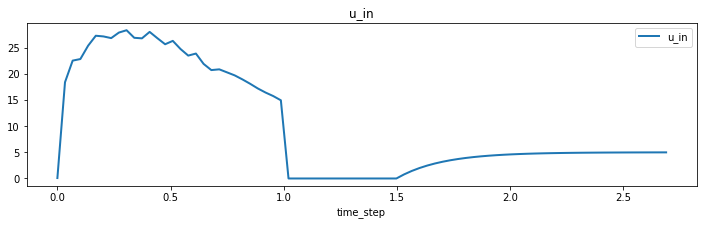

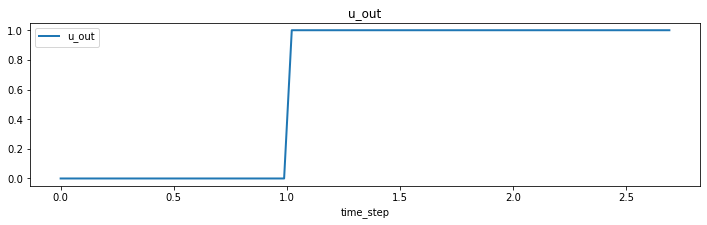

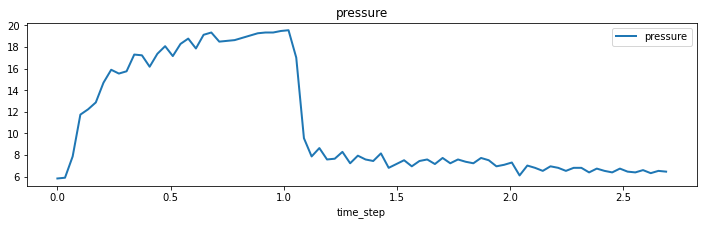

In [13]:
breath_one.plot(x="time_step", y="u_in", kind='line',figsize=(12,3), lw=2, title="u_in");
breath_one.plot(x="time_step", y="u_out", kind='line',figsize=(12,3), lw=2, title="u_out");
breath_one.plot(x="time_step", y="pressure", kind='line',figsize=(12,3), lw=2, title="pressure");

# All breaths
What values do we have for `R`, which represents how restricted the airway is (in cmH<sub>2</sub>O/L/S).

In [14]:
train_data.R.value_counts().to_frame()

,R
50,2410080
5,1988800
20,1637120


now for the values of `C`, the lung attribute indicating how compliant the lung is (in mL/cmH<sub>2</sub>O)

In [15]:
train_data.C.value_counts().to_frame()

,C
10,2244720
50,1971680
20,1819600


thus we have nine combinations of `R` and `C`. Let us look at a count of each of these combinations in the training data (dividing by 80 to account for the number time steps in each breath)

In [16]:
pd.crosstab(train_data["R"],train_data["C"]) /80

C,10,20,50
R,,,
5,8312.0,8277.0,8271.0
20,6070.0,6208.0,8186.0
50,13677.0,8260.0,8189.0


and similarly for the test data

In [17]:
pd.crosstab(test_data["R"],test_data["C"]) /80

C,10,20,50
R,,,
5,5437.0,5451.0,5447.0
20,4292.0,4088.0,5500.0
50,9081.0,5503.0,5501.0


We also have `u_out`, the control input for the exploratory solenoid valve. Either 0 or 1.

In [18]:
train_data.u_out.value_counts().to_frame()

,u_out
1,3745032
0,2290968


# Pressure
And now we shall look at the `pressure`. The pressure is measured in cmH<sub>2</sub>0, where 1 cmH<sub>2</sub>0 is roughly equal to 98 Pascals. The global peak inspiratory pressure (PIP) in the training data is

In [19]:
train_data.pressure.max()

64.8209917386395

This value is safely below the point where pressure relief valve opens (at 70 cmH<sub>2</sub>0) in order to prevent excessive pressures in the lung, thus reducing any barotrauma risk.

The pressures in the training data have the following distribution

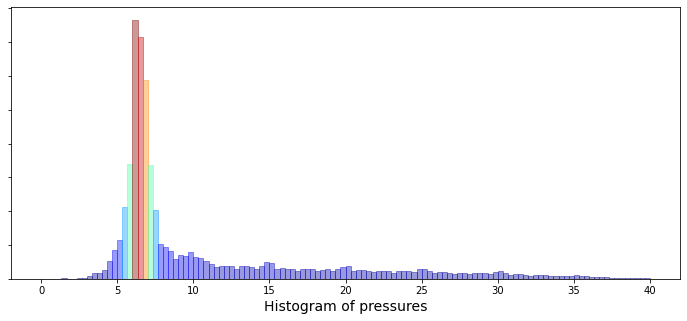

In [20]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['pressure'], 
             bins=120, 
             kde_kws={"clip":(0,40)}, 
             hist_kws={"range":(0,40)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of pressures", size=14)
ax.set(yticklabels=[])
plt.show();

with a median value of 

In [21]:
train_data.pressure.median()

7.032628177739799

Note however that in this competition the expiratory phase is not scored, so for practical purposes we are only really interested in the pressure for `u_out=0`, *i.e.* the first second of the experiments:

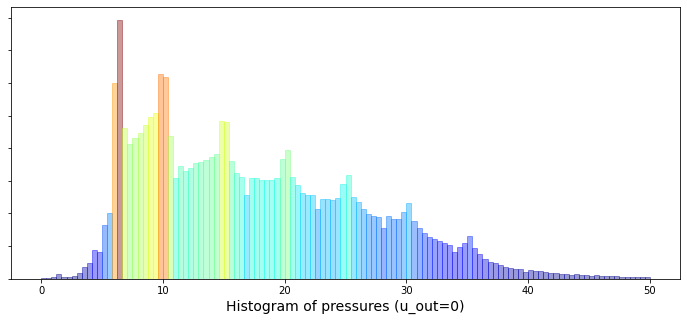

In [22]:
u_out_is_zero = train_data.query("u_out == 0").reset_index(drop = True)
plt.figure(figsize = (12,5))
ax = sns.distplot(u_out_is_zero['pressure'], 
             bins=120, 
             kde_kws={"clip":(0,50)}, 
             hist_kws={"range":(0,50)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of pressures (u_out=0)", size=14)
ax.set(yticklabels=[])
plt.show();

with a median value of 

In [23]:
u_out_is_zero.pressure.median()

15.82039635914182

We have nine combinations of experiments; `C` can be 10, 20 or 50, and `R` can be 5, 20 or 50. Lets take a quick look at an example of each

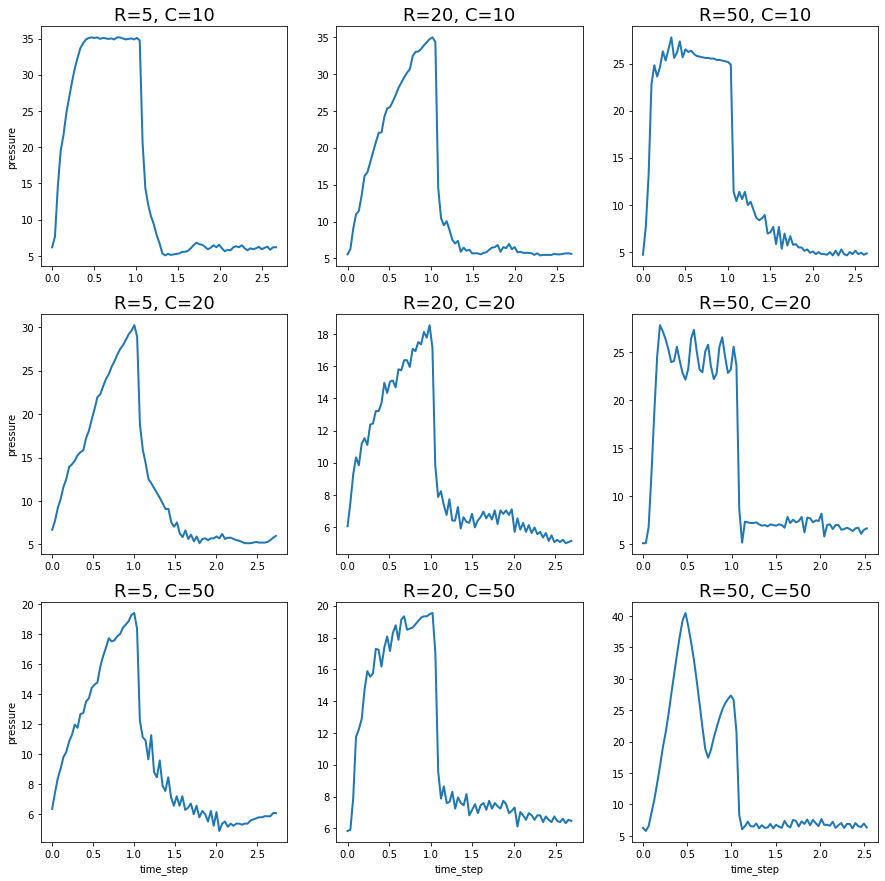

In [24]:
breath_2 = train_data.query('breath_id == 2').reset_index(drop = True)
breath_3 = train_data.query('breath_id == 3').reset_index(drop = True)
breath_4 = train_data.query('breath_id == 4').reset_index(drop = True)
breath_5 = train_data.query('breath_id == 5').reset_index(drop = True)
breath_17 = train_data.query('breath_id == 17').reset_index(drop = True)
breath_18 = train_data.query('breath_id == 18').reset_index(drop = True)
breath_21 = train_data.query('breath_id == 21').reset_index(drop = True)
breath_39 = train_data.query('breath_id == 39').reset_index(drop = True)

fig, axes = plt.subplots(3,3,figsize=(15,15))
sns.lineplot(data=breath_39, x="time_step", y="pressure", lw=2, ax=axes[0,0])
axes[0,0].set_title ("R=5, C=10", fontsize=18)
axes[0,0].set(xlabel='')
#axes[0,0].set(ylim=(0, None))
sns.lineplot(data=breath_21, x="time_step", y="pressure",  lw=2, ax=axes[0,1])
axes[0,1].set_title ("R=20, C=10", fontsize=18)
axes[0,1].set(xlabel='')
axes[0,1].set(ylabel='')
#axes[0,1].set(ylim=(0, None))
sns.lineplot(data=breath_18, x="time_step", y="pressure",  lw=2,ax=axes[0,2])
axes[0,2].set_title ("R=50, C=10", fontsize=18)
axes[0,2].set(xlabel='')
axes[0,2].set(ylabel='')
#axes[0,2].set(ylim=(0, None))
sns.lineplot(data=breath_17, x="time_step", y="pressure",  lw=2,ax=axes[1,0])
axes[1,0].set_title ("R=5, C=20", fontsize=18)
axes[1,0].set(xlabel='')
#axes[1,0].set(ylim=(0, None))
sns.lineplot(data=breath_2, x="time_step", y="pressure",  lw=2,ax=axes[1,1])
axes[1,1].set_title ("R=20, C=20", fontsize=18)
axes[1,1].set(xlabel='')
axes[1,1].set(ylabel='')
#axes[1,1].set(ylim=(0, None))
sns.lineplot(data=breath_3, x="time_step", y="pressure",  lw=2,ax=axes[1,2])
axes[1,2].set_title ("R=50, C=20", fontsize=18)
axes[1,2].set(xlabel='')
axes[1,2].set(ylabel='')
#axes[1,2].set(ylim=(0, None))
sns.lineplot(data=breath_5, x="time_step", y="pressure",  lw=2,ax=axes[2,0])
axes[2,0].set_title ("R=5, C=50", fontsize=18)
#axes[2,0].set(ylim=(0, None))
sns.lineplot(data=breath_one, x="time_step", y="pressure",  lw=2,ax=axes[2,1])
axes[2,1].set_title ("R=20, C=50", fontsize=18)
axes[2,1].set(ylabel='')
#axes[2,1].set(ylim=(0, None))
sns.lineplot(data=breath_4, x="time_step", y="pressure",  lw=2,ax=axes[2,2])
axes[2,2].set_title ("R=50, C=50", fontsize=18)
axes[2,2].set(ylabel='')
#axes[2,2].set(ylim=(0, None))

plt.show();

# Positive end-expiratory pressure (PEEP)
It is worth noting that even before the experiments start (*i.e.* the `time_step=0` and `u_in=0`) there is a positive pressure in the airway. The system is maintained above atmospheric pressure to promote gas exchange to the lungs.

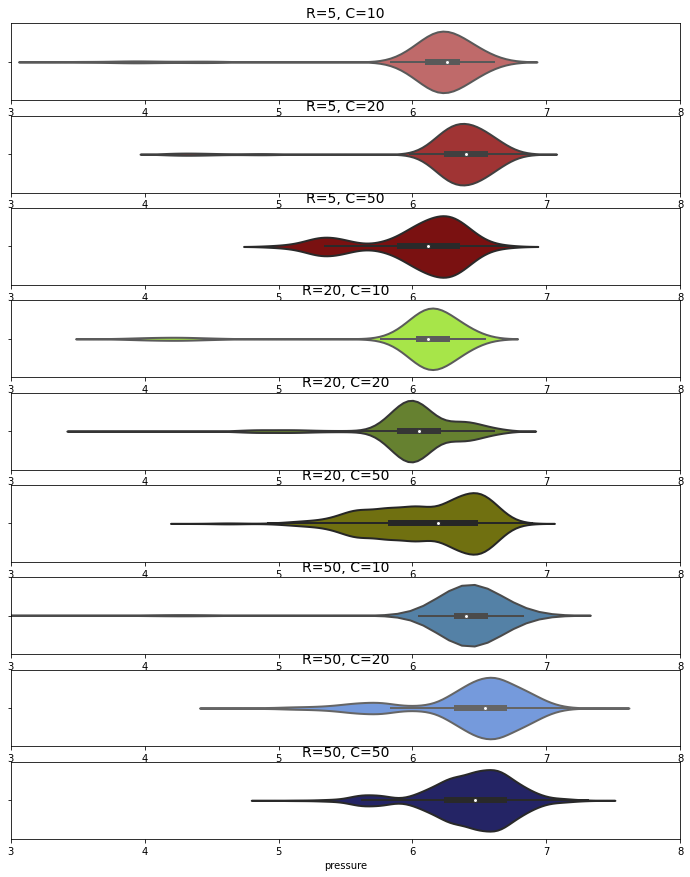

In [25]:
zero_time = train_data.query("time_step < 0.000001 & u_in < 0.000001").reset_index(drop = True)
zero_time_5_10  = zero_time.query("R ==  5 & C == 10").reset_index(drop = True)
zero_time_5_20  = zero_time.query("R ==  5 & C == 20").reset_index(drop = True)
zero_time_5_50  = zero_time.query("R ==  5 & C == 50").reset_index(drop = True)
zero_time_20_10 = zero_time.query("R == 20 & C == 10").reset_index(drop = True)
zero_time_20_20 = zero_time.query("R == 20 & C == 20").reset_index(drop = True)
zero_time_20_50 = zero_time.query("R == 20 & C == 50").reset_index(drop = True)
zero_time_50_10 = zero_time.query("R == 50 & C == 10").reset_index(drop = True)
zero_time_50_20 = zero_time.query("R == 50 & C == 20").reset_index(drop = True)
zero_time_50_50 = zero_time.query("R == 50 & C == 50").reset_index(drop = True)

fig, axes = plt.subplots(9,1,figsize=(12,15))
sns.violinplot(x=zero_time_5_10["pressure"], linewidth=2, ax=axes[0], color="indianred")
axes[0].set_title ("R=5, C=10", fontsize=14)
axes[0].set(xlim=(3, 8))
sns.violinplot(x=zero_time_5_20["pressure"], linewidth=2, ax=axes[1], color="firebrick")
axes[1].set_title ("R=5, C=20", fontsize=14)
axes[1].set(xlim=(3, 8))
sns.violinplot(x=zero_time_5_50["pressure"], linewidth=2, ax=axes[2], color="darkred" )
axes[2].set_title ("R=5, C=50", fontsize=14)
axes[2].set(xlim=(3, 8))
sns.violinplot(x=zero_time_20_10["pressure"], linewidth=2, ax=axes[3], color="greenyellow")
axes[3].set_title ("R=20, C=10", fontsize=14)
axes[3].set(xlim=(3, 8))
sns.violinplot(x=zero_time_20_20["pressure"], linewidth=2, ax=axes[4], color="olivedrab")
axes[4].set_title ("R=20, C=20", fontsize=14)
axes[4].set(xlim=(3, 8))
sns.violinplot(x=zero_time_20_50["pressure"], linewidth=2, ax=axes[5], color="olive" )
axes[5].set_title ("R=20, C=50", fontsize=14)
axes[5].set(xlim=(3, 8))
sns.violinplot(x=zero_time_50_10["pressure"], linewidth=2, ax=axes[6], color="steelblue")
axes[6].set_title ("R=50, C=10", fontsize=14)
axes[6].set(xlim=(3, 8))
sns.violinplot(x=zero_time_50_20["pressure"], linewidth=2, ax=axes[7], color="cornflowerblue")
axes[7].set_title ("R=50, C=20", fontsize=14)
axes[7].set(xlim=(3, 8))
sns.violinplot(x=zero_time_50_50["pressure"], linewidth=2, ax=axes[8], color="midnightblue" )
axes[8].set_title ("R=50, C=50", fontsize=14)
axes[8].set(xlim=(3, 8));

The average value of PEEP at the beginning of each cycle is

In [26]:
zero_time["pressure"].mean()

6.268396109353407

Note that not all cycles start with `u_in=0`, and a cycle can even start with the inspiratory solenoid valve set to the maximum value of 100.
# Exploratory perturbation policies
In the very interesting paper ["*Machine Learning for Mechanical Ventilation Control*"](https://arxiv.org/pdf/2102.06779.pdf) whose lead author is [Daniel Suo](https://www.kaggle.com/danielsuo), the host of this competition, they describe their experiments, examples of which can also be found in our dataset:

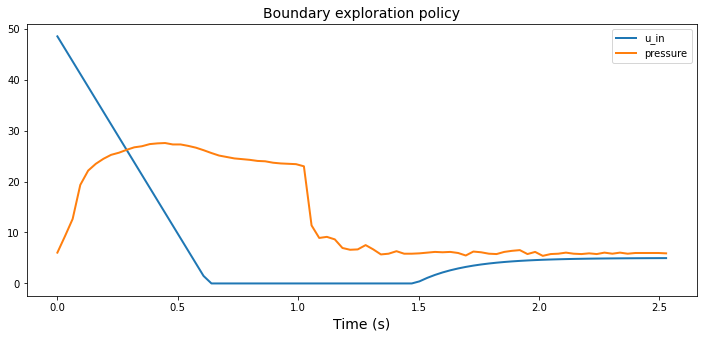

In [27]:
breath_3034 = train_data.query('breath_id == 3034').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(breath_3034["time_step"],breath_3034["u_in"], lw=2, label='u_in')
ax.plot(breath_3034["time_step"],breath_3034["pressure"], lw=2, label='pressure')
#ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_title("Boundary exploration policy", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=14)
plt.show();

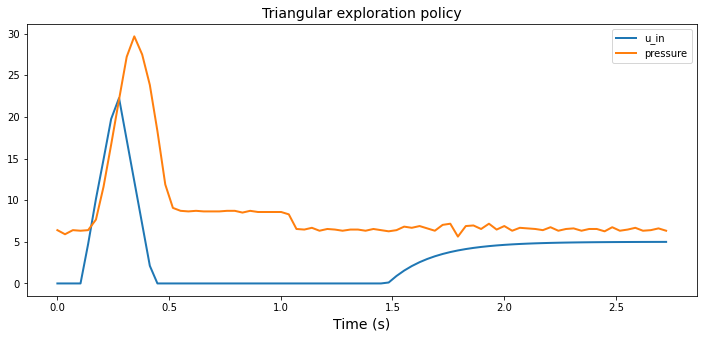

In [28]:
breath_3101 = train_data.query('breath_id == 3101').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(breath_3101["time_step"],breath_3101["u_in"], lw=2, label='u_in')
ax.plot(breath_3101["time_step"],breath_3101["pressure"], lw=2, label='pressure')
#ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_title("Triangular exploration policy", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=14)
plt.show();

# Negative pressure
The minimum value for the pressure where `u_in=0` at `time_step=0` is

In [29]:
zero_time[zero_time['pressure']==zero_time['pressure'].min()]

,breath_id,R,C,time_step,u_in,u_out,pressure
114,542,50,10,0.0,0.0,0,-1.825442
21863,119582,50,10,0.0,0.0,0,-1.825442


Both of these breaths have a somewhat unusual aspect

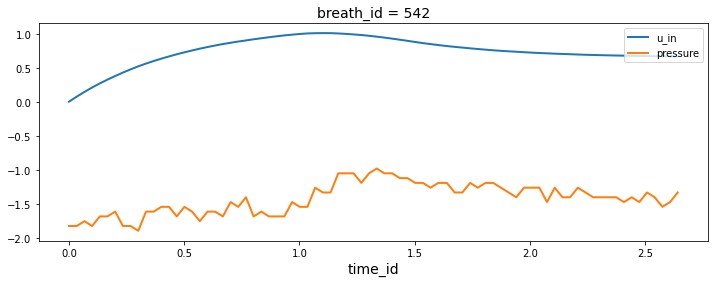

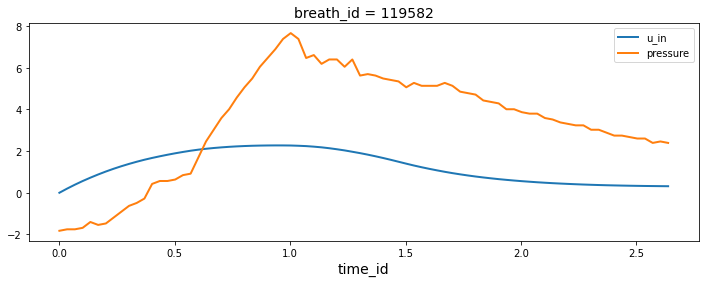

In [30]:
breath_542 = train_data.query('breath_id == 542').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(breath_542["time_step"],breath_542["u_in"], lw=2, label='u_in')
ax.plot(breath_542["time_step"],breath_542["pressure"], lw=2, label='pressure')
#ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
ax.set_title("breath_id = 542", fontsize=14)
plt.show();

breath_119582 = train_data.query('breath_id == 119582').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(breath_119582["time_step"],breath_119582["u_in"], lw=2, label='u_in')
ax.plot(breath_119582["time_step"],breath_119582["pressure"], lw=2, label='pressure')
#ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
ax.set_title("breath_id = 119582", fontsize=14)
plt.show();

Note that all of the instances of negative pressure occur only in the `R=50` (high restriction) with `C=10` (thick latex) systems.
# Simple feature engineering
We shall add a new feature, which is the [cumulative sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) of the `u_in` feature:

In [31]:
train_data['u_in_cumsum'] = (train_data['u_in']).groupby(train_data['breath_id']).cumsum()
test_data['u_in_cumsum']  = (test_data['u_in']).groupby(test_data['breath_id']).cumsum()

The thinking behind this feature is that it is reasonable to assume the pressure in the lungs is approximately proportional to how much air has actually been pumped into them. It goes almost without saying that this feature is not useful when breathing out, but given that the expiratory phase is not scored in this competition this should not be too much of a problem.

### Shifting `u_in`
Let us take a look at the first second of `breath_id=928`, which is an excellent example of an oscillatory experiment

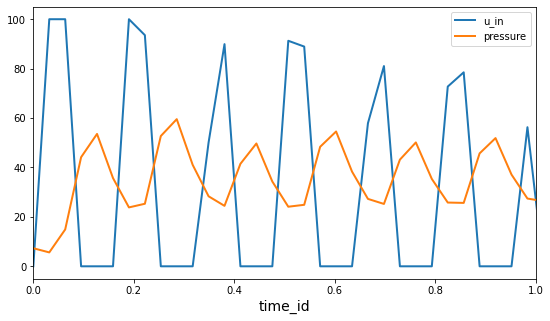

In [32]:
breath_928 = train_data.query('breath_id == 928').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot(breath_928["time_step"],breath_928["u_in"], lw=2, label='u_in')
ax.plot(breath_928["time_step"],breath_928["pressure"], lw=2, label='pressure')
ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
plt.show();

It can be observed that there is a lag between `u_in` and the resulting `pressure` of around 0.1 seconds. I am sure it is with this in mind that [Chun Fu](https://www.kaggle.com/patrick0302) wrote his excellent notebook ["*Add lag u_in as new feat*"](https://www.kaggle.com/patrick0302/add-lag-u-in-as-new-feat/notebook), which introduces a new *shifted* `u_in` feature. Here we shall use a shift of 2 rather than his original shift of 1, which is now more in line with the delay seen:

In [33]:
train_data['u_in_shifted'] = train_data.groupby('breath_id')['u_in'].shift(2).fillna(method="backfill")
test_data['u_in_shifted']  = test_data.groupby('breath_id')['u_in'].shift(2).fillna(method="backfill")

### Descriptive statistics of `u_in`
Again inspired by the work of Chun Fu, this time in his notebook ["*Add last u_in as new feat*"](https://www.kaggle.com/patrick0302/add-last-u-in-as-new-feat/) it is found, at least with gradient boosting type models, that providing the estimator with some descriptive statistics regarding `u_in` for the cycle in question seems to help in improving the model. Here are a number of examples, some of which may (or may not) be useful:

In [34]:
for df in (train_data, test_data):
    df['u_in_first']  = df.groupby('breath_id')['u_in'].transform('first')
    df['u_in_min']    = df.groupby('breath_id')['u_in'].transform('min')
    df['u_in_mean']   = df.groupby('breath_id')['u_in'].transform('mean')
    df['u_in_median'] = df.groupby('breath_id')['u_in'].transform('median')
    df['u_in_max']    = df.groupby('breath_id')['u_in'].transform('max')
    df['u_in_last']   = df.groupby('breath_id')['u_in'].transform('last')

# A simple submission

In [35]:
X_train = train_data.drop(['pressure'], axis=1)
y_train = train_data['pressure']
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble     import HistGradientBoostingRegressor
regressor  =  HistGradientBoostingRegressor(max_iter=100,
     loss="least_absolute_deviation",early_stopping=False)
regressor.fit(X_train, y_train)
sample["pressure"] = regressor.predict(test_data)
sample.to_csv('submission.csv',index=False)

In [36]:
test_data

,breath_id,R,C,time_step,u_in,u_out,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,
1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
2,0,5,20,0.031904,7.515046,0,7.515046,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
3,0,5,20,0.063827,14.651675,0,22.166721,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
4,0,5,20,0.095751,21.230610,0,43.397331,7.515046,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
5,0,5,20,0.127644,26.320956,0,69.718287,14.651675,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023996,125748,20,10,2.530117,4.971245,1,194.714841,4.959653,9.985853,0.0,2.682975,0.940477,35.151391,4.985373
4023997,125748,20,10,2.563853,4.975709,1,199.690549,4.965959,9.985853,0.0,2.682975,0.940477,35.151391,4.985373
4023998,125748,20,10,2.597475,4.979468,1,204.670017,4.971245,9.985853,0.0,2.682975,0.940477,35.151391,4.985373


In [37]:
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
2,1,20,50,0.033652,18.383041,0,5.907794,18.466375,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
3,1,20,50,0.067514,22.509278,0,7.876254,40.975653,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
4,1,20,50,0.101542,22.808822,0,11.742872,63.784476,18.383041,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
5,1,20,50,0.135756,25.355850,0,12.234987,89.140326,22.509278,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035996,125749,50,10,2.504603,1.489714,1,3.869032,387.109297,1.353205,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035997,125749,50,10,2.537961,1.488497,1,3.869032,388.597794,1.420711,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035998,125749,50,10,2.571408,1.558978,1,3.798729,390.156772,1.489714,6.030572,0.0,4.911402,1.694180,25.504196,1.482739


In [52]:
regressor.predict(tryt)

ValueError: X has 3 features but this estimator was trained with 14 features.

In [50]:
tryt=test_data.head(1)[['R','C','time_step']]

In [51]:
tryt

,R,C,time_step
id,,,
1,5,20,0.0


In [54]:
res=regressor.predict(test_data)

In [55]:
res/

NameError: name 'y_test' is not defined

In [62]:
from sklearn.model_selection import train_test_split
x_tr, x_t, y_tr, y_t = train_test_split(train_data,y_train, test_size=0.33, random_state=42)

In [59]:
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
2,1,20,50,0.033652,18.383041,0,5.907794,18.466375,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
3,1,20,50,0.067514,22.509278,0,7.876254,40.975653,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
4,1,20,50,0.101542,22.808822,0,11.742872,63.784476,18.383041,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
5,1,20,50,0.135756,25.355850,0,12.234987,89.140326,22.509278,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035996,125749,50,10,2.504603,1.489714,1,3.869032,387.109297,1.353205,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035997,125749,50,10,2.537961,1.488497,1,3.869032,388.597794,1.420711,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035998,125749,50,10,2.571408,1.558978,1,3.798729,390.156772,1.489714,6.030572,0.0,4.911402,1.694180,25.504196,1.482739


In [60]:
X_train

,breath_id,R,C,time_step,u_in,u_out,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,
1,1,20,50,0.000000,0.083334,0,0.083334,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
2,1,20,50,0.033652,18.383041,0,18.466375,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
3,1,20,50,0.067514,22.509278,0,40.975653,0.083334,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
4,1,20,50,0.101542,22.808822,0,63.784476,18.383041,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
5,1,20,50,0.135756,25.355850,0,89.140326,22.509278,0.083334,0.0,10.146007,4.922568,28.313036,4.987079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035996,125749,50,10,2.504603,1.489714,1,387.109297,1.353205,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035997,125749,50,10,2.537961,1.488497,1,388.597794,1.420711,6.030572,0.0,4.911402,1.694180,25.504196,1.482739
6035998,125749,50,10,2.571408,1.558978,1,390.156772,1.489714,6.030572,0.0,4.911402,1.694180,25.504196,1.482739


In [67]:
pred=regressor.predict(x_t.drop(['pressure'],axis=1))

In [68]:
pred

array([ 4.70321376,  9.00863453, 18.53081478, ...,  4.74817119,
        8.30008355,  6.42261499])

In [70]:
from sklearn.metrics import mean_squared_error
#Original Model
mean_squared_error(y_t,pred)

2.529437474336427

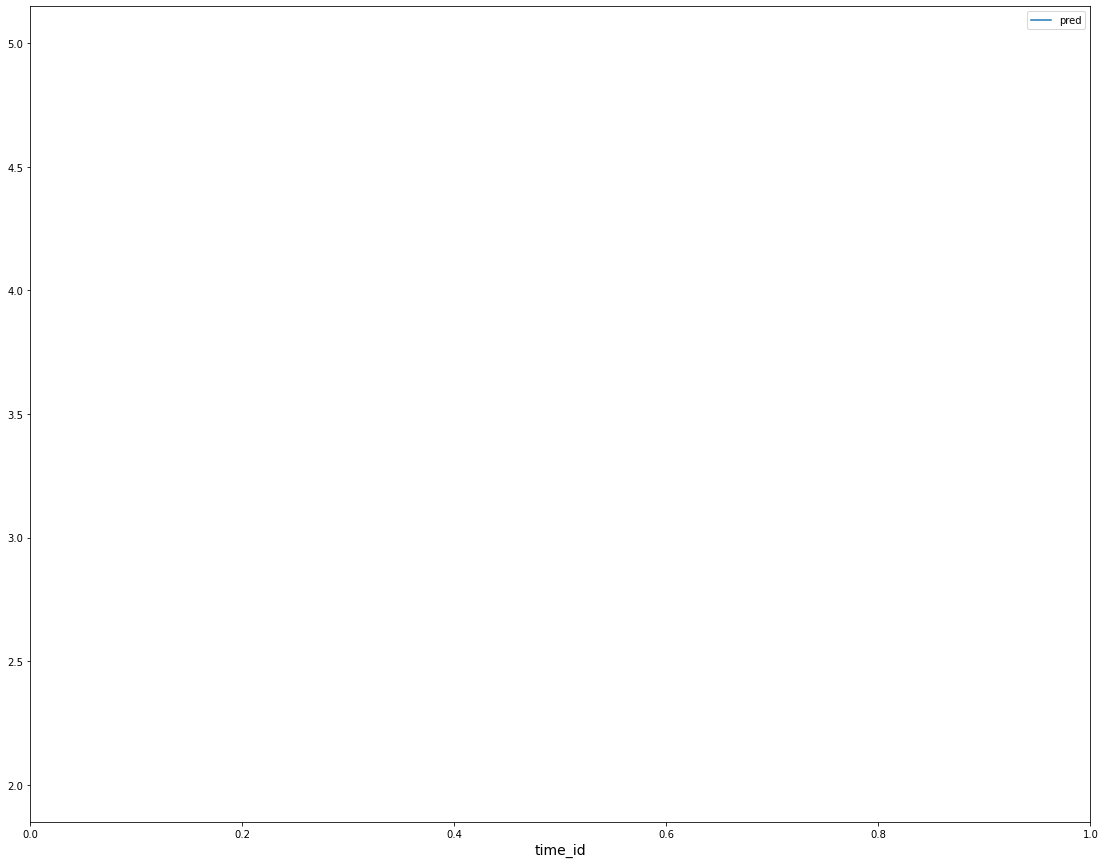

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(19, 15))
ax.plot(pred[1:5],indices[1:5], label='pred')
# ax.plot(y_t,indices,  label='y_t')
ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
plt.show();

In [71]:
indices=[]
for i in range(1,len(pred)+1):
    indices.append(i)
indices

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

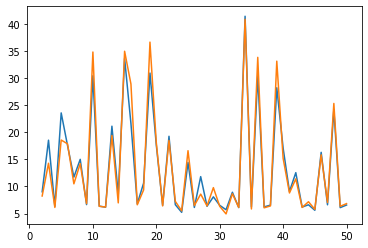

In [115]:
x=50
plt.plot(indices[1:x], pred[1:x], label = "line 1") #blue pred
plt.plot(indices[1:x], y_t[1:x], label = "line 1") #orange truth

plt.show()

In [81]:
type(y_t)

pandas.core.series.Series

In [109]:
# X_train = train_data.drop(['pressure'], axis=1)
# y_train = train_data['pressure']
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble     import HistGradientBoostingRegressor
regressor2  =  HistGradientBoostingRegressor(max_iter=100,
     loss="least_absolute_deviation",early_stopping=False)
regressor2.fit(x_tr[['R',	'C',	'time_step','u_in','u_out']], y_tr)
# sample["pressure"] = regressor.predict(test_data)
# sample.to_csv('submission.csv',index=False)

HistGradientBoostingRegressor(early_stopping=False,
                              loss='least_absolute_deviation')

In [110]:
pred2=regressor2.predict(x_t[['R',	'C',	'time_step','u_in','u_out']])
#Stripped Down Just Necessary Inputs
mean_squared_error(y_t,pred2)

18.47617752984108

In [105]:
x_tr

,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,,
3219529,66993,50,50,0.256153,15.080822,0,22.288194,144.062883,15.991054,15.200939,0.000000,6.802280,4.905012,16.998412,4.971428
2786948,58025,5,10,2.263673,4.891037,1,6.189002,321.108391,4.847255,1.947328,0.000000,4.757431,4.455168,19.223091,4.985627
5128202,106842,20,20,1.393892,0.000000,1,5.907794,202.174023,0.000000,0.000000,0.000000,4.377322,4.846834,8.076682,4.987134
408756,8458,20,10,1.180557,0.000000,1,10.547735,338.151511,0.000000,0.000000,0.000000,6.053789,4.537836,23.823760,4.985573
518512,10773,20,20,0.994280,0.000000,1,21.936683,430.139710,0.000000,39.751476,0.000000,7.084428,4.327227,39.751476,4.974829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570007,32628,50,10,0.201093,12.373697,0,12.586498,88.630364,13.882640,3.353088,0.892143,4.919052,3.102384,17.085136,1.185646
2234490,46461,5,50,0.306136,70.553180,0,16.593720,742.328137,75.709670,12.495337,0.000000,21.946490,4.934978,100.000000,4.987200
4926485,102639,50,10,0.126467,0.000000,0,22.850611,114.204844,0.000000,14.204844,0.000000,5.166411,0.994902,100.000000,4.966650


In [111]:
test_data

,breath_id,R,C,time_step,u_in,u_out,u_in_cumsum,u_in_shifted,u_in_first,u_in_min,u_in_mean,u_in_median,u_in_max,u_in_last
id,,,,,,,,,,,,,,
1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
2,0,5,20,0.031904,7.515046,0,7.515046,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
3,0,5,20,0.063827,14.651675,0,22.166721,0.000000,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
4,0,5,20,0.095751,21.230610,0,43.397331,7.515046,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
5,0,5,20,0.127644,26.320956,0,69.718287,14.651675,0.000000,0.0,9.327338,4.683875,37.542219,4.973375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023996,125748,20,10,2.530117,4.971245,1,194.714841,4.959653,9.985853,0.0,2.682975,0.940477,35.151391,4.985373
4023997,125748,20,10,2.563853,4.975709,1,199.690549,4.965959,9.985853,0.0,2.682975,0.940477,35.151391,4.985373
4023998,125748,20,10,2.597475,4.979468,1,204.670017,4.971245,9.985853,0.0,2.682975,0.940477,35.151391,4.985373
